# Examining the Settling Time of NIRCam Grism Time Series

In [1]:
import numpy as np
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table

In [2]:
nints = 1336
x = np.linspace(0,4. * 3600.,nints)

Polynomial trend

Text(0,0.5,u'Normalized Flux')

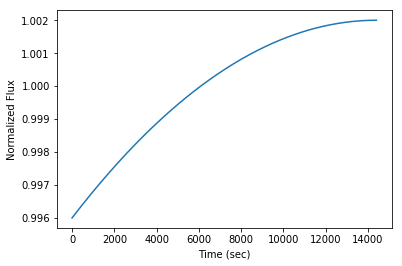

In [3]:
x_norm = 2. * (x - np.mean(x)) / (np.max(x) - np.min(x))
leg0 = 1.0
leg1 = x_norm
leg2 = 0.5 * (3. * x_norm**2 - 1.0)
leg3 = 0.5 * (5. * x_norm**3 - 3. * x_norm)
y_poly = 1.0 * leg0 + 0.003 * leg1 - 0.001 * leg2# + 0.1 * leg3

plt.plot(x,y_poly)
plt.xlabel("Time (sec)")
plt.ylabel("Normalized Flux")

Exponential trend

Text(0,0.5,u'Normalized Flux')

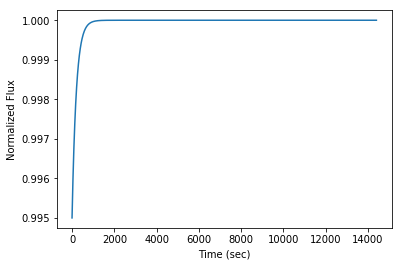

In [4]:
tau_true = 200.
exp_amp = 0.005
y_exp = -exp_amp * np.exp(-x / tau_true) + 1.
plt.plot(x,y_exp)
plt.xlabel("Time (sec)")
plt.ylabel("Normalized Flux")

Gaussian Noise and cosmic ray outliers

In [5]:
np.random.seed(5)
## Gaussian
gauss_sig = 100e-6 ## detector + photon estimate from experience w/ other tests
gauss_noise = np.random.randn(nints) * gauss_sig

## Cosmic Rays
n_cr = 8
amp_cr = 0.005
cr_pts = np.random.randint(low=0,high=nints-1,size=n_cr)
cr_noise = np.zeros_like(y_poly)
cr_noise[cr_pts] = np.random.randn(n_cr) * amp_cr

all_noise = gauss_noise + cr_noise

All together

Text(0,0.5,u'Normalized Flux')

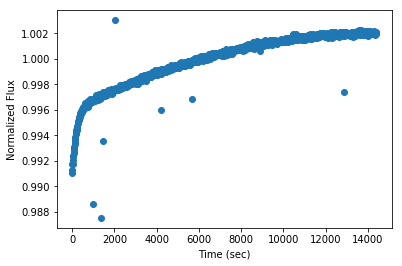

In [6]:
ysim = y_poly * y_exp + all_noise

t = Table()
t['Time'] = x
t['Flux'] = ysim
t.write('sim_data_ex1.csv',overwrite=True)

plt.plot(x,ysim,'o')
plt.xlabel("Time (sec)")
plt.ylabel("Normalized Flux")

Define model

In [7]:
def poly_fun(x_in,poly0=1.0, poly1=0.0, poly2=0.0,poly3=0.0):
    return poly0 + poly1 * x_in + poly2 * x_in**2 + poly3 * x_in**3

def exp_fun(x_in,amp_exp=1.0,tau=1.0):
    return -amp_exp * np.exp(-x_in / tau) + 1.

@custom_model
def exp_model(x_in,amp_exp=1.0,tau=1.0,poly0=1.0, poly1=0.0, poly2=0.0,poly3=0.0):
    """
    Exponential model
    """
    #y_exp = -amp_exp * np.exp(-x_in / tau) + 1.
    #y_poly = poly0 + poly1 * x_in + poly2 * x_in**2 + poly3 * x_in**3
    #
    y_exp = exp_fun(x_in,amp_exp,tau)
    y_poly = poly_fun(x_in,poly0,poly1,poly2,poly3)
    return y_exp * y_poly



model_test1 = exp_model()
model_test1(10.)

0.9999546000702375

In [8]:
fit = fitting.LevMarLSQFitter()

In [9]:
model_to_fit = exp_model()
fitted_model = fit(model_to_fit,x,ysim)

Amp = 0.00486484452425
Tau = 181.482684844


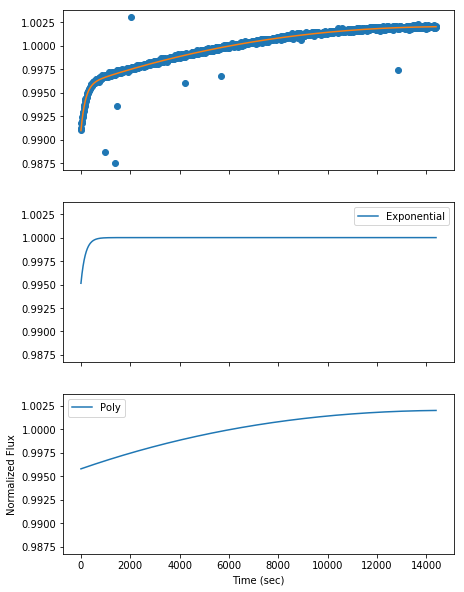

In [10]:
def plot_results(resmodel,x1,ysim1):
    fig, (ax,ax1,ax2) = plt.subplots(3,sharex=True,sharey=True,figsize=(7,10))
    ax.plot(x1,ysim1,'o')
    ax.plot(x1,resmodel(x1))
    
    #ax.set_ylabel("Normalized Flux")
    yexp1 = exp_fun(x1,resmodel.amp_exp,fitted_model.tau)
    ypoly1 = poly_fun(x1,resmodel.poly0,resmodel.poly1,resmodel.poly2,
                      resmodel.poly3)
    
    ax1.plot(x1,yexp1,label='Exponential')
    ax1.legend()
    
    
    ax2.plot(x1,ypoly1,label='Poly')
    ax2.legend()
    
    ax2.set_ylabel("Normalized Flux")
    ax2.set_xlabel("Time (sec)")

    print("Amp = {}".format(resmodel.amp_exp.value))
    print("Tau = {}".format(resmodel.tau.value))
plot_results(fitted_model,x,ysim)

## Now simulate a lightcurve w/ no exponential

Amp = -6.17277650879e-05
Tau = 32.2179524659


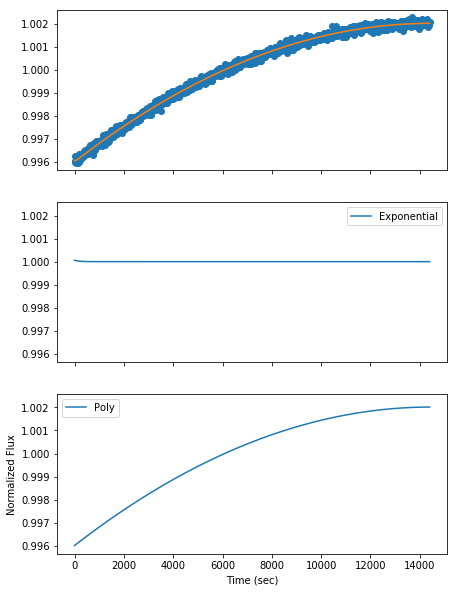

In [11]:
ysim2 = y_poly + gauss_noise
#plt.plot(x,ysim2,'o')
fitted_model2 = fit(model_to_fit,x,ysim2)

plot_results(fitted_model2,x,ysim2)
#plt.plot(x,fitted_model2(x))